   Maturity (years)  Discount Factor  Zero-Coupon Yield (%)
0              0.08           0.9964                 4.3378
1              0.25           0.9893                 4.3132
2              0.50           0.9789                 4.2652
3              1.00           0.9586                 4.2281
4              2.00           0.9186                 4.2450
5              3.00           0.8791                 4.2962
6              5.00           0.8034                 4.3781
7              7.00           0.7313                 4.4713
8             10.00           0.6335                 4.5644
9             30.00           0.2380                 4.7856


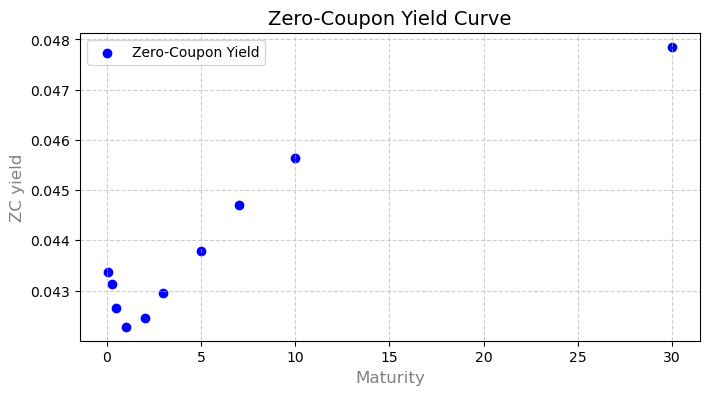

In [12]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()

    # Prepare data for DataFrame
    data = []
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        data.append([round(t, 2), round(df, 4), round(zcy, 4)])

    # Create DataFrame
    df_results = pd.DataFrame(data, columns=["Maturity (years)", "Discount Factor", "Zero-Coupon Yield (%)"])

    # Display DataFrame
    print(df_results)

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(df_results["Maturity (years)"], df_results["Zero-Coupon Yield (%)"] / 100, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

# Run the main function
main()


Nelson-Siegel-Svensson Fitting Results:
              Value
β₀         0.048674
β₁        -0.005336
β₂         0.993158
β₃        -1.006863
τ          0.995946
θ          1.004052
Objective   2.9e-06


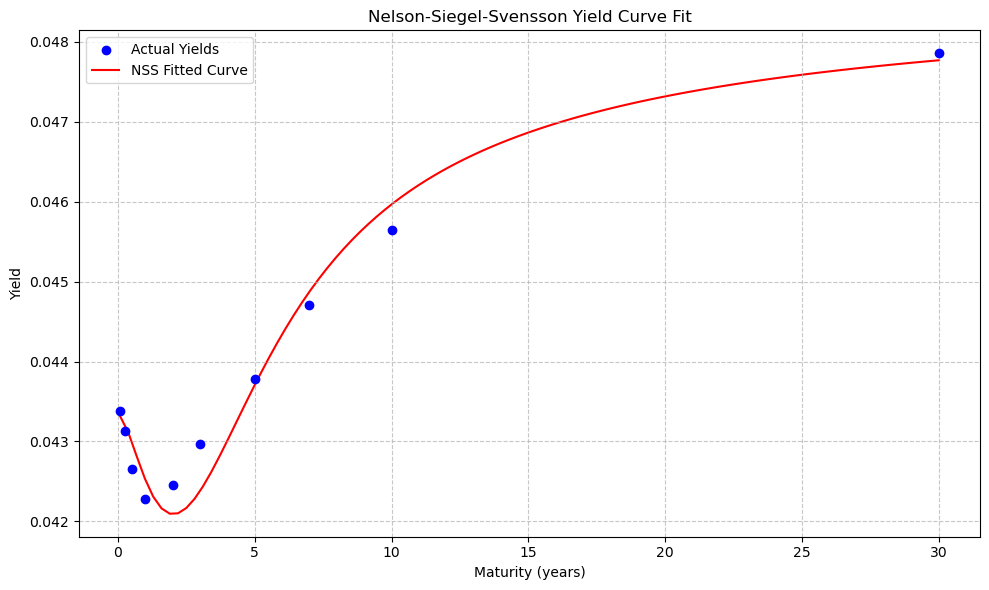

In [27]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 2.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t
                          maturities)    # Long end: weight by t
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.035,  # a (long-term level)
        0.01,   # b
        1.0,    # c
        -1.0,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result


calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
# Create DataFrame
results_df = pd.DataFrame({
    'Value': result.x
}, index=['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ'])
# Add objective function value at the bottom
obj_value = f"{result.fun:.1e}" 
results_df.loc['Objective'] = obj_value

print("\nNelson-Siegel-Svensson Fitting Results:")
print(results_df)

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


Calibrated Parameters:
               Parameter    Value
θ (Mean reversion level) 0.020000
κ (Mean reversion speed) 0.022686
          σ (Volatility) 0.162029

Model Fit Metrics:
                  Metric    Value
Objective Function Value 0.077970
    Optimization Success     True
    Number of Iterations       12


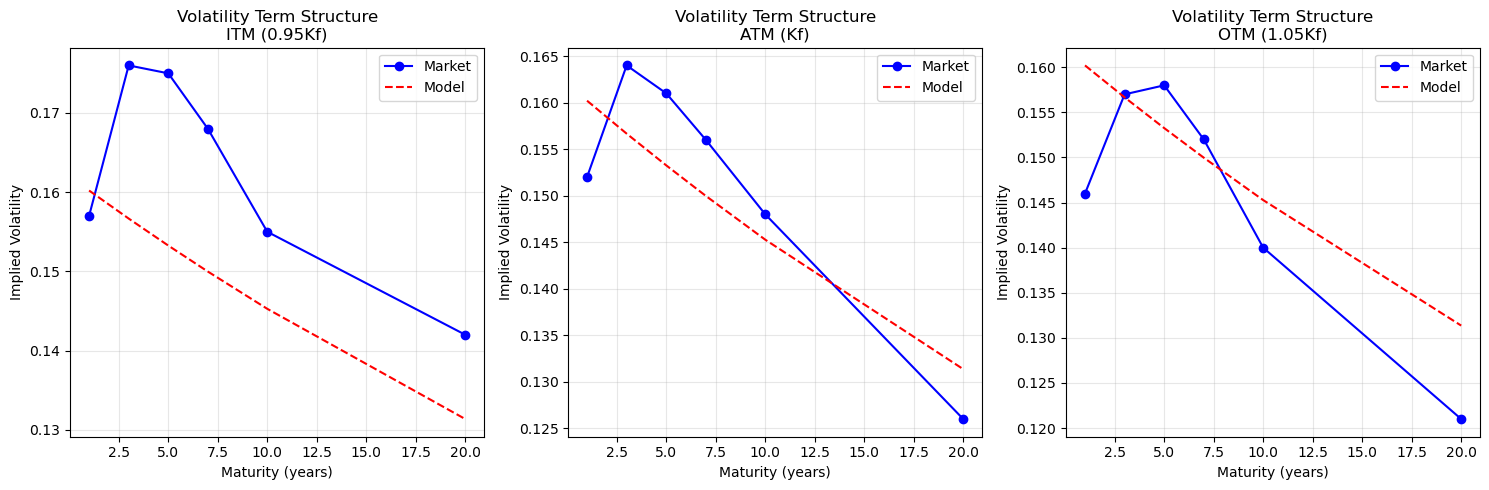

In [33]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class CapMarketCalibrator:
    def __init__(self, t=0.003):  # January 16th
        # Market data structure
        self.t = t  # fraction of year elapsed
        self.K_ratios = [0.95, 1.0, 1.05]  # Strike ratios relative to forward rate
        self.T_years = [1, 3, 5, 7, 10, 20]  # Maturities
        
        # Market implied volatilities
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        # Initialize discount factor calculator
        self.zc_calculator = ZeroCouponCalculator()
        self.discount_factors = self._get_interpolated_discount_factors()

    def _get_interpolated_discount_factors(self):
        """Create interpolation function for discount factors"""
        df_dict = {**self.zc_calculator.bills_discount_factors,
                  **self.zc_calculator.calculate_all_discount_factors()}
        maturities = sorted(df_dict.keys())
        factors = [df_dict[t] for t in maturities]
        return interp1d(maturities, factors, kind='cubic', fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate from discount factors"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """
        Black's formula for cap price calculation
        
        Parameters:
        F: Forward rate
        K: Strike rate
        T: Time to maturity
        sigma: Volatility
        P_T: Discount factor
        """
        if abs(F - K) < 1e-10:  # Handle ATM case
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        option_price = P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))
        return option_price

    def cap_market_price(self, j, k):
        """
        Calculate market cap price using market implied volatility
        
        Parameters:
        j: Strike index (0: 0.95Kf, 1: Kf, 2: 1.05Kf)
        k: Maturity index (corresponds to T_years)
        """
        T = self.T_years[k]
        F = self.get_forward_rate(T)
        K = self.K_ratios[j] * F
        sigma = self.vol_market[k, j]
        P_T = float(self.discount_factors(T))
        
        return self.black_formula(F, K, T, sigma, P_T)

    def cap_model_price(self, K, T, theta, kappa, sigma):
        """
        Calculate theoretical cap price using Brigo-Mercurio model
        
        Parameters:
        K: Strike rate
        T: Time to maturity
        theta, kappa, sigma: Model parameters
        """
        F = self.get_forward_rate(T)
        # Implement Brigo-Mercurio specific volatility calculation
        vol = sigma * np.sqrt((1 - np.exp(-2 * kappa * T)) / (2 * kappa * T))
        P_T = float(self.discount_factors(T))
        
        return self.black_formula(F, K, T, vol, P_T)

    def objective_function(self, params):
        """
        Calculate sum of squared relative errors between model and market prices
        This implements the minimization formula from the problem statement
        """
        theta, kappa, sigma = params
        error = 0
        
        for j in range(3):  # For each strike (0.95Kf, Kf, 1.05Kf)
            for k in range(6):  # For each maturity
                T = self.T_years[k]
                F = self.get_forward_rate(T)
                K = self.K_ratios[j] * F
                
                cap_model = self.cap_model_price(K, T, theta, kappa, sigma)
                cap_market = self.cap_market_price(j, k)
                
                if cap_market != 0:
                    relative_error = (cap_model - cap_market) / cap_market
                    error += relative_error ** 2
                    
        return error

    def calibrate(self, initial_guess=None):
        """Calibrate the model parameters"""
        if initial_guess is None:
            initial_guess = [0.02, 0.5, 0.2]  # theta, kappa, sigma
            
        bounds = [(0.0001, 0.1), (0.0001, 2.0), (0.0001, 0.5)]
        
        result = opt.minimize(
            self.objective_function,
            x0=initial_guess,
            method='L-BFGS-B',
            bounds=bounds
        )
        
        return result

    def plot_volatility_surface(self, optimal_params):
        """Plot market vs model implied volatilities for each strike"""
        theta, kappa, sigma = optimal_params
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        strike_labels = ['ITM (0.95Kf)', 'ATM (Kf)', 'OTM (1.05Kf)']
        
        for j in range(3):
            ax = axes[j]
            
            # Plot market volatilities
            market_vols = self.vol_market[:, j]
            ax.plot(self.T_years, market_vols, 'o-', 
                   label='Market', color='blue')
            
            # Plot model-implied volatilities
            model_vols = []
            for k, T in enumerate(self.T_years):
                F = self.get_forward_rate(T)
                K = self.K_ratios[j] * F
                vol = sigma * np.sqrt((1 - np.exp(-2 * kappa * T)) / (2 * kappa * T))
                model_vols.append(vol)
            
            ax.plot(self.T_years, model_vols, '--', 
                   label='Model', color='red')
            
            ax.set_title(f'Volatility Term Structure\n{strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    # Create calibrator
    calibrator = CapMarketCalibrator()
    
    # Perform calibration
    result = calibrator.calibrate()
    
    # Create results DataFrame
    param_data = [
        ['θ (Mean reversion level)', f"{result.x[0]:.6f}"],
        ['κ (Mean reversion speed)', f"{result.x[1]:.6f}"],
        ['σ (Volatility)', f"{result.x[2]:.6f}"]
    ]
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    
    # Create fit metrics DataFrame
    metrics_data = [
        ['Objective Function Value', f"{result.fun:.6f}"],
        ['Optimization Success', str(result.success)],
        ['Number of Iterations', str(result.nit)]
    ]
    df_metrics = pd.DataFrame(metrics_data, columns=['Metric', 'Value'])
    
    # Display results
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    print("\nModel Fit Metrics:")
    print(df_metrics.to_string(index=False))
    
    # Plot results
    calibrator.plot_volatility_surface(result.x)

if __name__ == "__main__":
    main()